# Time Series Classification

**Shiyu Mou**

** shiyumou@usc.edu **


In this problem, I will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

The dataset was downloaded from: https://archive.ics.uci.edu/ml/datasets/ Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\ %29 . The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities
of the same person. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

In this practice, various ways of feature engineering were tested, logistic regression and naive bayes were used and compared. 

In [123]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from sklearn import preprocessing

In [2]:
# init
data_dict = 'AReM/'
prefix = 'dataset'
filetype = '.csv'
classes = ['walking', 'standing', 'sitting', 'lying', 'cycling', 'bending1', 'bending2']

In [3]:
# trace function
def trace(obj):
    print(obj)
    pass

**(c) i** : Minimum, maximum, mean, median, standard deviation, first quartile, and third quartile are usually used in time series classification. 

### Load data
**(c) ii**

In [4]:
def load_data(num_parts):
    train_dataset = list()
    test_dataset = list()
    for label in range(len(classes)):    
        class_path = data_dict + classes[label] + '/'
        path, dirs, files = next(os.walk(class_path))
        file_count = len(files)
#         trace(file_count)
        classData_train = list()
        classData_test = list()
        for fileIndex in range(1, file_count+1):
            csvname = class_path + prefix + str(fileIndex) + filetype
    #         print('processing ', csvname)
            df = pd.read_csv(csvname, skiprows=range(0, 4))
            num_singlepart = int(df.shape[0]/num_parts)
            for i in range(0, num_parts):
                df_p = df[:num_singlepart]
                df = df.drop(df.index[:num_singlepart])
                stat_pd = df_p.describe().drop('count').drop(columns='# Columns: time').transpose()
                newInstance = pd.concat([stat_pd.loc['avg_rss12'], 
                                         stat_pd.loc['var_rss12'], 
                                         stat_pd.loc['avg_rss13'], 
                                         stat_pd.loc['var_rss13'], 
                                         stat_pd.loc['avg_rss23'], 
                                         stat_pd.loc['var_rss23']], 
                                         axis=0, sort=False)

                newInstance = newInstance.to_frame().transpose()
                newInstance.columns = ['mean1', 'std1', 'min1', '25%_1', 
                                       '50%_1', '75%_1', 'max1', 'mean2', 'std2', 'min2', '25%_2', 
                                       '50%_2', '75%_2', 'max2', 'mean3', 'std3', 'min3', '25%_3', 
                                       '50%_3', '75%_3', 'max3', 'mean4', 'std4', 'min4', '25%_4', 
                                       '50%_4', '75%_4', 'max4', 'mean5', 'std5', 'min5', '25%_5', 
                                       '50%_5', '75%_5', 'max5', 'mean6', 'std6', 'min6', '25%_6', 
                                       '50%_6', '75%_6', 'max6'] 
            #     print(newInstance)
#                 classData.append(newInstance)
                if classes[label] == 'bending1' or classes[label] == 'bending2':
                    if fileIndex == 1 or fileIndex == 2:
                        classData_test.append(newInstance)
                    else:
                        classData_train.append(newInstance)
                else:
                    if fileIndex == 1 or fileIndex == 2 or fileIndex == 3:
                        classData_test.append(newInstance)
                    else:
                        classData_train.append(newInstance)
                        
        classData_test = pd.concat(classData_test, ignore_index=True)
        classData_train = pd.concat(classData_train, ignore_index=True)
        classData_train['label'] = classes[label]
        classData_test['label'] = classes[label]
        if classes[label]=='bending1' or classes[label]=='bending2':
            classData_train['label_b'] = 1
            classData_test['label_b'] = 1    
        else:
            classData_train['label_b'] = 0
            classData_test['label_b'] = 0              
#         dataset.append(classData) 
        train_dataset.append(classData_train)
        test_dataset.append(classData_test)
    train_dataset = pd.concat(train_dataset, ignore_index=True, sort=False)
    test_dataset = pd.concat(test_dataset, ignore_index=True, sort=False)
    return train_dataset, test_dataset

In [5]:
train_dataset, test_dataset = load_data(1)
train_dataset.shape

(69, 44)

## Binary Classification

**(c) iii**: The three most important time-domain features I selected are min, mean, and max. 

**(d) i**

In [6]:
def select_data(train, test):    
    selected_features = ['min1', 'max1', 'mean1', 'min2', 
                         'max2', 'mean2', 'min6', 'max6', 'mean6', 'label_b']
    train_selected = train[selected_features]
    test_selected = test[selected_features]
    return train_selected, test_selected
train_selected, test_selected = select_data(train_dataset, train_dataset)

In [7]:
train_selected.head()

,min1,max1,mean1,min2,max2,mean2,min6,max6,mean6,label_b
0,18.00,46.00,35.193333,0.0,16.20,4.321021,0.0,8.50,3.241958,0
1,20.75,46.25,34.763333,0.0,12.68,4.223792,0.0,9.39,3.288271,0
2,21.50,51.00,34.935812,0.0,12.21,4.115750,0.0,10.21,3.280021,0
3,18.33,47.67,34.333042,0.0,12.48,4.396958,0.0,8.01,3.261583,0
4,18.33,45.75,34.599875,0.0,15.37,4.398833,0.0,8.86,3.289542,0


### (d) i

['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']


/Users/ShiyuMu/anaconda/envs/ML/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/Users/ShiyuMu/anaconda/envs/ML/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/Users/ShiyuMu/anaconda/envs/ML/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/Users/ShiyuMu/anaconda/envs/ML/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expandi

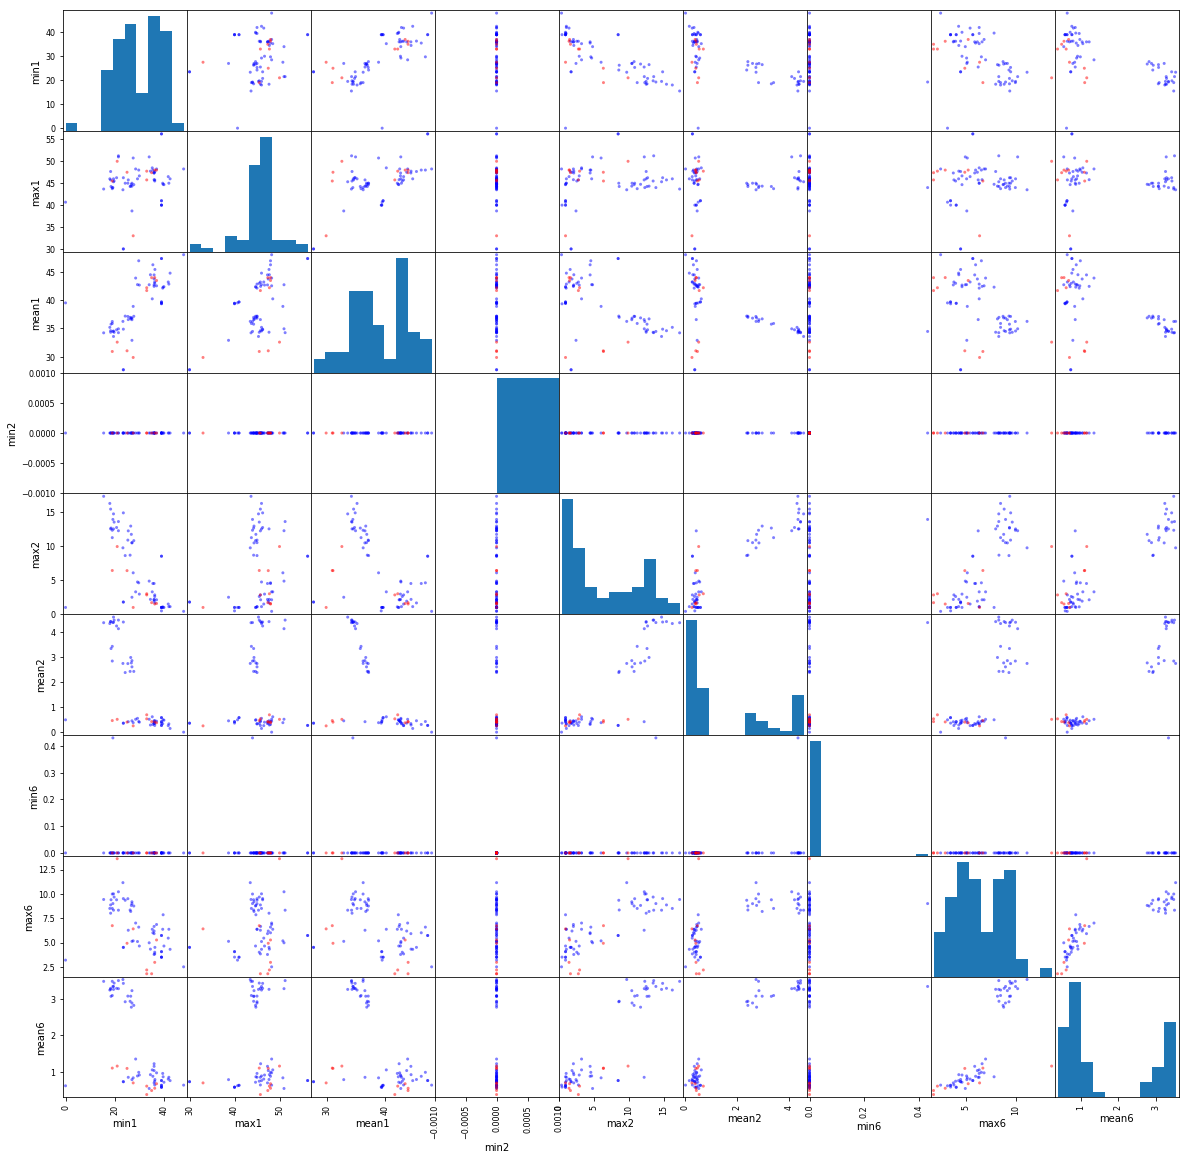

In [8]:
def plotScatter(df):
    color_list = list()
    for i in df["label_b"]:
        if i == 1:
            color_list.append('r')
        else:
            color_list.append('b')
    trace(color_list)
    pd.plotting.scatter_matrix(df.iloc[:,:9], color=color_list, figsize=(20,20))
plotScatter(train_selected)

## (d) ii
Break dataset into two


**Observation**: After break time series into two, the scatters of different classes look more seperatable

In [9]:
train_dataset_2, test_dataset_2 = load_data(2)
train_selected_break12, test_selected_break12 = select_data(train_dataset_2, test_dataset_2)
test_selected_break12.head()

,min1,max1,mean1,min2,max2,mean2,min6,max6,mean6,label_b
0,22.33,42.50,34.334833,0.00,12.19,3.974958,0.0,9.74,3.387500,0
1,19.33,43.50,34.120708,0.00,14.50,4.016500,0.0,8.86,3.400750,0
2,18.67,45.00,33.762958,0.43,13.05,4.400833,0.0,8.46,3.378708,0
3,12.50,43.25,33.256500,0.00,12.85,4.500708,0.0,8.96,3.378250,0
4,15.00,45.33,33.591625,0.00,12.53,4.573042,0.0,8.99,3.281958,0


['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']


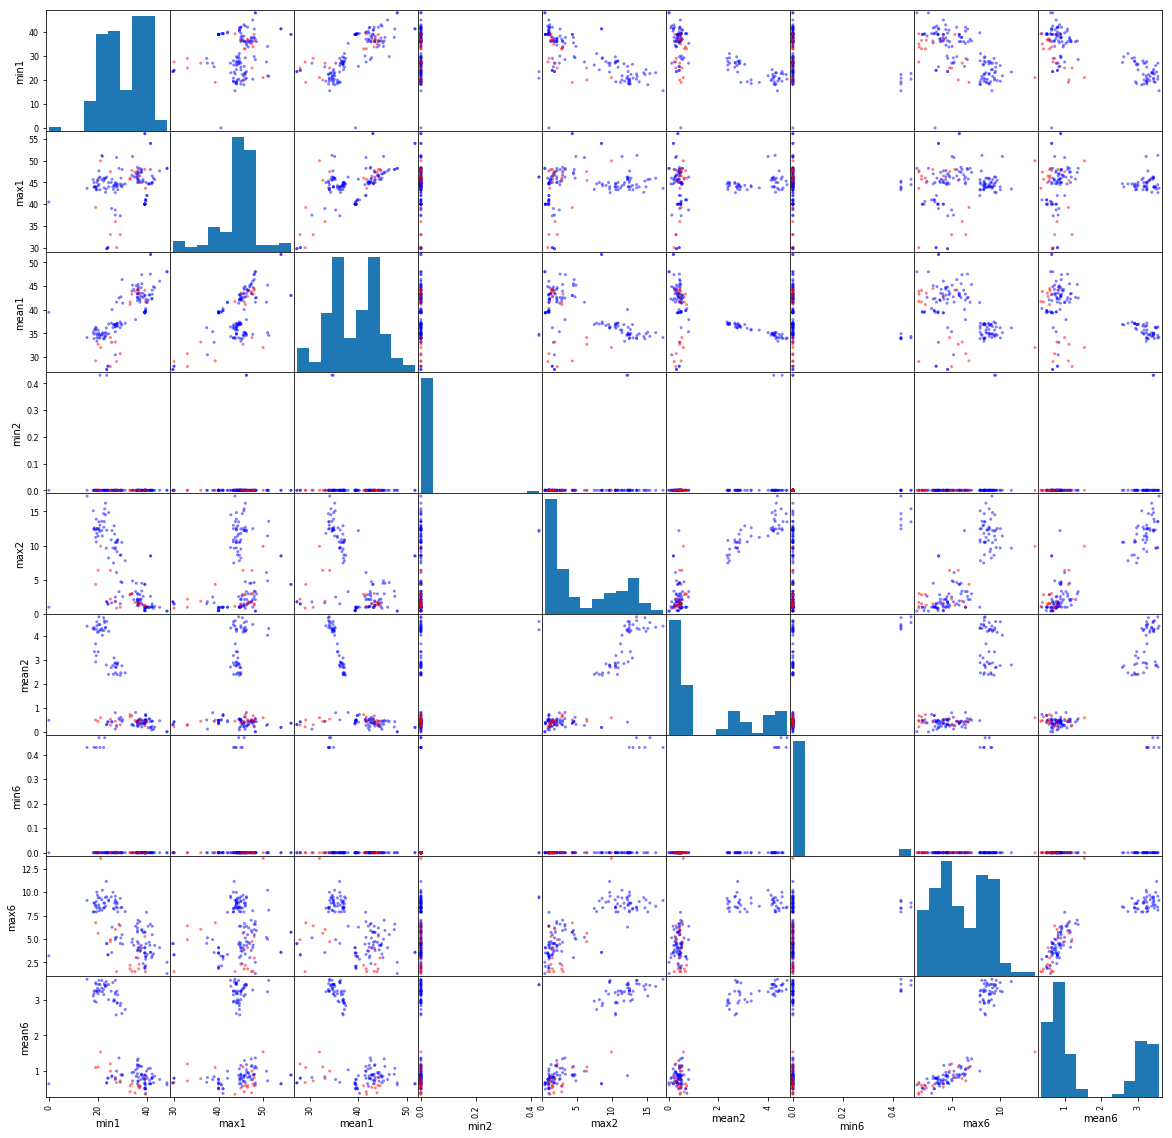

In [10]:
plotScatter(train_selected_break12)

## (d) iii

In [11]:
l_list = [i for i in range(1,21)]
l_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [40]:
def select_best_l(l_list):
    score_report = list()
    for l in l_list:
        train_dataset_l, test_dataset_l = load_data(l)
        train_X = train_dataset_l.iloc[:, 0:-2]
        train_Y = train_dataset_l['label_b']

        model = LogisticRegression()     
        Nfold = 5
        cv = StratifiedKFold(n_splits=Nfold, shuffle=True)

        score_list = list()
        for train_index, cv_index in cv.split(train_X, train_Y):

            X_train_k, X_cv = train_X.loc[train_index], train_X.loc[cv_index]
            y_train_k, y_cv = train_Y.loc[train_index], train_Y.loc[cv_index]

            rfe = RFE(model, 8)
            rfe = rfe.fit(X_train_k, y_train_k)

            signif_list = list()
            for i in range(len(rfe.support_)):
                if rfe.support_[i]==True:
                    signif_list.append(i)
            y_predict = model.fit(X_train_k[X_train_k.columns[signif_list]], 
                                            y_train_k).predict(X_cv[X_cv.columns[signif_list]])
            score_list.append(f1_score(y_cv, y_predict, average='weighted'))
        print(l, score_list)
        score_report.append(score_list)
    return score_report

In [41]:
score_report = select_best_l(l_list)

1 [1.0, 1.0, 1.0, 1.0, 1.0]
2 [0.8683229813664595, 1.0, 0.9620991253644313, 0.8789115646258503, 1.0]
3 [0.8268991282689913, 0.9482625482625483, 0.9512195121951219, 0.9024390243902439, 0.9744217990125106]
4 [0.9620991253644313, 0.9436378054934756, 0.8980716253443526, 0.9060630091557926, 0.9272727272727272]
5 [0.9020236425566018, 0.8840579710144928, 0.9317831926527579, 0.9211735595616827, 0.8810702341137123]


/Users/ShiyuMu/anaconda/envs/ML/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


6 [0.9156024096385543, 0.8059075009716284, 0.9098650240057976, 0.9139454369200942, 0.9186717205009888]
7 [0.8675865863546854, 0.8850150579190263, 0.9202868323302148, 0.9093023255813955, 0.9319767441860466]
8 [0.9118397585402661, 0.929800853485064, 0.9302542083826567, 0.9116427432216906, 0.8467848581438845]
9 [0.9304118766653978, 0.8466261492909458, 0.9516129032258065, 0.974720770414616, 0.9516129032258065]
10 [0.9020236425566018, 0.9278356773030488, 0.9369388476493462, 0.893374741200828, 0.9641819370762431]


/Users/ShiyuMu/anaconda/envs/ML/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


11 [0.8072646404744255, 0.9309535099008784, 0.9149638802889578, 0.9496577740897026, 0.9321842132926135]
12 [0.9100750829404576, 0.9385324549429245, 0.9128044646116934, 0.8895057962172056, 0.9299226187162501]
13 [0.8774390243902439, 0.9204569055036345, 0.8060798228395994, 0.9145324904439872, 0.9145217538513629]
14 [0.9182545325275506, 0.9194420318068826, 0.8964254694659918, 0.9634142859339274, 0.9172583056712712]
15 [0.9173108469632313, 0.9455165465395645, 0.9400286669851888, 0.8425413073089234, 0.8965869808656702]
16 [0.927687594699123, 0.9192555100483489, 0.9239819004524887, 0.8323130157040192, 0.840975935828877]
17 [0.8992835154057809, 0.9286884916194202, 0.9207152815663453, 0.9543885601577908, 0.9029413474086873]
18 [0.836068254920133, 0.911902690074876, 0.912799969725966, 0.9200254845416137, 0.9326908726520692]
19 [0.9297825335517516, 0.8784995571125732, 0.9768022570449318, 0.8487319412024478, 0.9079289253264046]
20 [0.8175190809213604, 0.9101883390102185, 0.9335421768598856, 0.813

# 

In [42]:
score_df = pd.DataFrame(score_report)
score_df.index = score_df.index + 1
score_df = pd.DataFrame(score_df.mean(axis=1))
score_df.columns = ['score']
score_df.index.names = ['l_value']
score_df

,score
l_value,
1,1.000000
2,0.941867
3,0.920648
4,0.927429
5,0.904022
6,0.892798
7,0.902834
8,0.906064
9,0.930997


**The best 'l' is 1**

The right way is to put feature selection step within the loop of k-fold CV, cause different way of spliting data may give you different best features. Whe wrong way is to do feature selection ahead of spliting data.

## (d) iv :
l = 1 and number of feature is 10

In [210]:
train_dataset_1, test_dataset_1 = load_data(1)
train_X = train_dataset_1.iloc[:, 0:-2]
train_Y = train_dataset_1['label_b']
test_X = test_dataset_1.iloc[:, 0:-2]
test_Y = test_dataset_1['label_b']

In [214]:
def train(train_X, train_Y, test_X, test_Y):
    model = LogisticRegression(max_iter=100)  
    rfe = RFE(model, 10)
    rfe = rfe.fit(train_X, train_Y)

    signif_list = list()
    for i in range(len(rfe.support_)):
        if rfe.support_[i]==True:
            signif_list.append(i)
    clf = model.fit(train_X[train_X.columns[signif_list]], 
                          train_Y)
    y_predict = clf.predict(train_X[train_X.columns[signif_list]])
    y_score = clf.decision_function(train_X[train_X.columns[signif_list]])
    params = np.append(clf.intercept_,clf.coef_)
    print(train_X.columns[signif_list])
    return y_predict, y_score, signif_list, clf
y_predict, y_score, signif_list, clf = train(train_X, train_Y, test_X, test_Y)

Index(['mean1', '75%_1', '75%_2', 'max2', '50%_3', 'mean5', 'min5', '25%_5',
       'max5', 'max6'],
      dtype='object')


In [215]:
def report(train_X, train_Y, y_predict, y_score, signif_list):
    
    con_matrix = confusion_matrix(train_Y, y_predict)
    fpr, tpr, thresholds = roc_curve(train_Y, y_score, pos_label=1)
    
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic and AUC')
    plt.legend(loc="lower right")
    plt.show()
    print("Confusion Matrix:\n ", con_matrix)
#     print('paramters: ', param)
    newX = sm.add_constant(train_X[train_X.columns[signif_list]])
    est = sm.Logit(train_Y, train_X[train_X.columns[signif_list]]).fit(method="bfgs")
#     est = sm.OLS(train_Y, train_X[train_X.columns[signif_list]]).fit()
    print(est.summary())

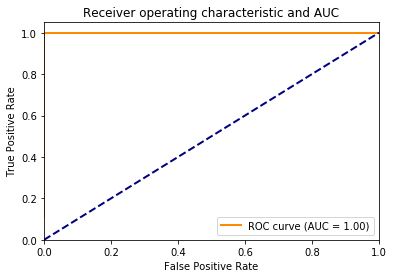

Confusion Matrix:
  [[60  0]
 [ 0  9]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
                           Logit Regression Results                           
Dep. Variable:                label_b   No. Observations:                   69
Model:                          Logit   Df Residuals:                       59
Method:                           MLE   Df Model:                            9
Date:                Sun, 01 Jul 2018   Pseudo R-squ.:                   1.000
Time:                        21:26:10   Log-Likelihood:            -9.8486e-06
converged:                       True   LL-Null:                       -26.718
                                        LLR p-value:                 2.417e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [216]:
report(train_X, train_Y, y_predict, y_score, signif_list)

We can see the cofficients column and P>|t| columns which is the p-value column

## (d) v

In [97]:
y_predict_test = clf.predict(test_X[test_X.columns[signif_list]])
test_score = f1_score(test_Y, y_predict_test, average='weighted')
compare_df = pd.DataFrame()
compare_df = dict()
compare_df = {'Validation Score':score_df.iloc[0,0], 'Test Score':test_score}
compare_df = pd.DataFrame.from_dict(compare_df, orient='index')
compare_df

,0
Validation Score,1.0
Test Score,1.0


## (d) vi
From the warning we can see we have a well-seprated problem. 

## (d) vii
From the confusion matrix, we can see there's 60 "not bending", but only 9 'bending'. So here I'm going to perfrom downsampling to make the number of 'not bending' 5 times as number of 'bending'.  

In [131]:
# select 15 instances from 60 to delete
print(train_dataset_1.shape)
randomSampleList = np.random.choice(60, 15, replace=False)
print(randomSampleList)
dsp_train_dataset_1 = train_dataset_1.drop(randomSampleList)
dsp_train_dataset_1.shape

(69, 44)
[ 8 27 12 10 16  1 49 24 50 57 29 11 41 59 21]


(54, 44)

In [132]:
train_X_dsp = dsp_train_dataset_1.iloc[:, 0:-2]
train_Y_dsp = dsp_train_dataset_1['label_b']
test_X_dsp = test_dataset_1.iloc[:, 0:-2]
test_Y_dsp = test_dataset_1['label_b']

In [133]:
y_predict_dsp, y_score_dsp, signif_list_dsp, clf = train(train_X_dsp, train_Y_dsp, 
                                                    test_X_dsp, test_Y_dsp)

Index(['mean1', '75%_1', '75%_2', 'max2', '50%_3', 'mean5', 'min5', '25%_5',
       'max5', 'max6'],
      dtype='object')


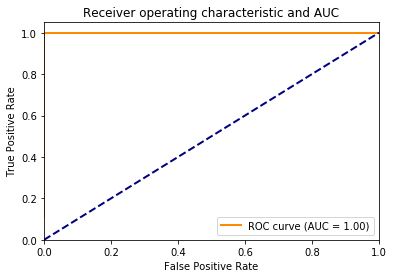

Confusion Matrix:
  [[45  0]
 [ 0  9]]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
                           Logit Regression Results                           
Dep. Variable:                label_b   No. Observations:                   54
Model:                          Logit   Df Residuals:                       44
Method:                           MLE   Df Model:                            9
Date:                Sun, 01 Jul 2018   Pseudo R-squ.:                   1.000
Time:                        17:24:05   Log-Likelihood:            -8.5968e-06
converged:                       True   LL-Null:                       -24.330
                                        LLR p-value:                 1.922e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [134]:
report(train_X_dsp, train_Y_dsp, y_predict_dsp, y_score_dsp, signif_list_dsp)

## (e) i 

In [146]:
def select_best_l_l1_norm(l_list):
    score_report = list()
    for l in l_list:
        train_dataset_l, test_dataset_l = load_data(l)
        train_X = train_dataset_l.iloc[:, 0:-2]
        train_Y = train_dataset_l['label_b']
        train_X_norm = normalize(train_X)    
        test_X = test_dataset_l.iloc[:, 0:-2]
        test_Y = test_dataset_l['label_b']
        test_X_norm = normalize(test_X)
        

        model = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=10, refit=True)
        model = model.fit(train_X_norm, train_Y)
        score_cv = model.score(test_X_norm, test_Y)
        print(l, score_cv)
        score_report.append(score_cv)
    return score_report

In [147]:
score_report_l1 = select_best_l_l1_norm(l_list)

1 1.0
2 0.9736842105263158
3 1.0
4 0.9868421052631579
5 1.0
6 0.9649122807017544
7 0.9699248120300752
8 0.993421052631579
9 0.9766081871345029
10 0.9736842105263158
11 0.9712918660287081
12 0.9868421052631579
13 0.979757085020243
14 0.9774436090225563
15 0.9789473684210527
16 0.9769736842105263
17 0.9814241486068112
18 0.9824561403508771
19 0.9861495844875346
20 0.9789473684210527


## (e) ii
Apparently we got better average results than the p-value method as shown below. What's more, it's easier to implement.  

In [163]:
score_df_l1 = pd.DataFrame(score_report_l1)
score_df_l1.index = score_df_l1.index + 1
# score_df_l1 = pd.DataFrame(score_df.mean(axis=1))
score_df_l1.columns = ['score']
score_df_l1.index.names = ['l_value']
score_df_l1

,score
l_value,
1,1.000000
2,0.973684
3,1.000000
4,0.986842
5,1.000000
6,0.964912
7,0.969925
8,0.993421
9,0.976608


In [119]:
def normalize(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df

## (f) i
### L1 norm logistic regression

In [150]:
def load_data_multi_class(num_parts):
    train_dataset = list()
    test_dataset = list()
    for label in range(len(classes)):    
        class_path = data_dict + classes[label] + '/'
        path, dirs, files = next(os.walk(class_path))
        file_count = len(files)
#         trace(file_count)
        classData_train = list()
        classData_test = list()
        for fileIndex in range(1, file_count+1):
            csvname = class_path + prefix + str(fileIndex) + filetype
    #         print('processing ', csvname)
            df = pd.read_csv(csvname, skiprows=range(0, 4))
            num_singlepart = int(df.shape[0]/num_parts)
            for i in range(0, num_parts):
                df_p = df[:num_singlepart]
                df = df.drop(df.index[:num_singlepart])
                stat_pd = df_p.describe().drop('count').drop(columns='# Columns: time').transpose()
                newInstance = pd.concat([stat_pd.loc['avg_rss12'], 
                                         stat_pd.loc['var_rss12'], 
                                         stat_pd.loc['avg_rss13'], 
                                         stat_pd.loc['var_rss13'], 
                                         stat_pd.loc['avg_rss23'], 
                                         stat_pd.loc['var_rss23']], 
                                         axis=0, sort=False)

                newInstance = newInstance.to_frame().transpose()
                newInstance.columns = ['mean1', 'std1', 'min1', '25%_1', 
                                       '50%_1', '75%_1', 'max1', 'mean2', 'std2', 'min2', '25%_2', 
                                       '50%_2', '75%_2', 'max2', 'mean3', 'std3', 'min3', '25%_3', 
                                       '50%_3', '75%_3', 'max3', 'mean4', 'std4', 'min4', '25%_4', 
                                       '50%_4', '75%_4', 'max4', 'mean5', 'std5', 'min5', '25%_5', 
                                       '50%_5', '75%_5', 'max5', 'mean6', 'std6', 'min6', '25%_6', 
                                       '50%_6', '75%_6', 'max6'] 
            #     print(newInstance)
#                 classData.append(newInstance)
                if classes[label] == 'bending1' or classes[label] == 'bending2':
                    if fileIndex == 1 or fileIndex == 2:
                        classData_test.append(newInstance)
                    else:
                        classData_train.append(newInstance)
                else:
                    if fileIndex == 1 or fileIndex == 2 or fileIndex == 3:
                        classData_test.append(newInstance)
                    else:
                        classData_train.append(newInstance)
                        
        classData_test = pd.concat(classData_test, ignore_index=True)
        classData_train = pd.concat(classData_train, ignore_index=True)
        classData_train['label'] = classes[label]
        classData_test['label'] = classes[label]          
#         dataset.append(classData) 
        train_dataset.append(classData_train)
        test_dataset.append(classData_test)
    train_dataset = pd.concat(train_dataset, ignore_index=True, sort=False)
    test_dataset = pd.concat(test_dataset, ignore_index=True, sort=False)
    return train_dataset, test_dataset

In [161]:
def select_best_l_l1_norm_multi_class(l_list):
    score_report = list()
    for l in l_list:
        train_dataset_l, test_dataset_l = load_data_multi_class(l)
        train_X = train_dataset_l.iloc[:, 0:-1]
        train_Y = train_dataset_l['label']
        train_X_norm = normalize(train_X)    
        test_X = test_dataset_l.iloc[:, 0:-1]
        test_Y = test_dataset_l['label']
        test_X_norm = normalize(test_X)
        

        model = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=10, refit=True)
        model = model.fit(train_X_norm, train_Y)
        score_cv = model.score(test_X_norm, test_Y)
        print(l, score_cv)
        score_report.append(score_cv)
    return score_report

In [169]:
score_report_l1_multi_class = select_best_l_l1_norm_multi_class(l_list)

1 0.9473684210526315
2 0.7368421052631579
3 0.7894736842105263
4 0.7368421052631579
5 0.7052631578947368
6 0.8333333333333334
7 0.8120300751879699
8 0.8355263157894737
9 0.8070175438596491
10 0.7842105263157895
11 0.861244019138756
12 0.8289473684210527
13 0.8137651821862348
14 0.7819548872180451
15 0.8210526315789474
16 0.805921052631579
17 0.7987616099071208
18 0.827485380116959
19 0.814404432132964
20 0.7736842105263158


In [177]:
summary_multi_class = pd.DataFrame(score_report_l1_multi_class)
summary_multi_class.index = summary_multi_class.index+1
summary_multi_class = pd.DataFrame(summary_multi_class.mean(axis=1))
summary_multi_class.columns = ['Test score']
summary_multi_class.index.names = ['l_value']
summary_multi_class

,Test score
l_value,
1,0.947368
2,0.736842
3,0.789474
4,0.736842
5,0.705263
6,0.833333
7,0.812030
8,0.835526
9,0.807018


In [295]:
train_dataset_1, test_dataset_1 = load_data_multi_class(1)
train_X = train_dataset_1.iloc[:, 0:-1]
train_Y = train_dataset_1['label']
test_X = test_dataset_1.iloc[:, 0:-1]
test_Y = test_dataset_1['label']

In [296]:
def train_multi_class(train_X, train_Y, test_X, test_Y):
    test_X_norm = normalize(test_X)
    train_X_norm = normalize(train_X)  

    model = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=10, refit=True)
    model = model.fit(train_X_norm, train_Y)
    y_predict = model.predict(test_X_norm)
    y_score = model.decision_function(test_X_norm)

    params = np.append(model.intercept_,model.coef_)

    return train_X_norm, train_Y, test_Y, y_predict, y_score, model

train_X_norm, train_Y, test_Y, y_predict, y_score, clf_multi_class = train_multi_class(train_X, train_Y, test_X, test_Y)

In [299]:
from itertools import cycle
from scipy import interp
from sklearn.preprocessing import label_binarize
def report_multi_class(train_X_norm, train_Y, test_Y, y_predict, y_score):
    lw = 2
    con_matrix = confusion_matrix(test_Y, y_predict)    
    train_Y = label_binarize(train_Y, classes=classes)
    test_Y = label_binarize(test_Y, classes=classes)
    y_predict = label_binarize(y_predict, classes=classes)
    n_classes = train_Y.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'pink', 'olive', 
                    'brown', 'wheat'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="upper left")
    plt.show()
    
    print("Confusion Matrix: \n", con_matrix)

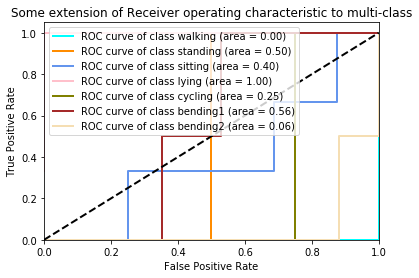

Confusion Matrix: 
 [[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


In [298]:
report_multi_class(train_X_norm, train_Y, test_Y, y_predict, y_score)

The best l is 1

## (e) ii

### Gaussian Bayes

In [197]:
from sklearn.naive_bayes import GaussianNB
def Gaussian_Bayes(l_list):
    score_report = list()
    for l in l_list:
        train_dataset_l, test_dataset_l = load_data(l)
        train_X = train_dataset_l.iloc[:, 0:-2]
        train_Y = train_dataset_l['label_b']
        train_X_norm = normalize(train_X)    
        test_X = test_dataset_l.iloc[:, 0:-2]
        test_Y = test_dataset_l['label_b']
        test_X_norm = normalize(test_X)
        
        gnb = GaussianNB()
        model = gnb.fit(train_X, train_Y)
        score_cv = model.score(test_X, test_Y)
        print(l, score_cv)
        score_report.append(score_cv)
    return score_report

In [198]:
score_report_GNB = Gaussian_Bayes(l_list)

1 0.5789473684210527
2 0.5263157894736842
3 0.5263157894736842
4 0.5263157894736842
5 0.5263157894736842
6 0.5175438596491229
7 0.5263157894736842
8 0.5263157894736842
9 0.5380116959064327
10 0.5263157894736842
11 0.5598086124401914
12 0.5394736842105263
13 0.5384615384615384
14 0.5413533834586466
15 0.5298245614035088
16 0.5296052631578947
17 0.544891640866873
18 0.5584795321637427
19 0.5484764542936288
20 0.5342105263157895


### Multi-nomial Bayes

In [200]:
from sklearn.naive_bayes import MultinomialNB
def Multi_normial_Bayes(l_list):
    score_report = list()
    for l in l_list:
        train_dataset_l, test_dataset_l = load_data(l)
        train_X = train_dataset_l.iloc[:, 0:-2]
        train_Y = train_dataset_l['label_b']
        train_X_norm = normalize(train_X)    
        test_X = test_dataset_l.iloc[:, 0:-2]
        test_Y = test_dataset_l['label_b']
        test_X_norm = normalize(test_X)
        
        clf = MultinomialNB()
        model = clf.fit(train_X, train_Y)
        score_cv = model.score(test_X, test_Y)
        print(l, score_cv)
        score_report.append(score_cv)
    return score_report

In [201]:
score_report_MNNB = Multi_normial_Bayes(l_list)

1 1.0
2 0.9473684210526315
3 0.9298245614035088
4 0.8947368421052632
5 0.9157894736842105
6 0.9035087719298246
7 0.8872180451127819
8 0.8881578947368421
9 0.8947368421052632
10 0.8947368421052632
11 0.8899521531100478
12 0.8728070175438597
13 0.8744939271255061
14 0.868421052631579
15 0.8736842105263158
16 0.868421052631579
17 0.8699690402476781
18 0.8801169590643275
19 0.8698060941828255
20 0.8605263157894737


## (f) iii

After comparation, we can see Multi-nomial Naive Bayes has better performance which gives best test score 1.00.